In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

import numpy as np
import torch
from torch import nn

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor

In [2]:
transform = Compose([ToTensor(), nn.Flatten(start_dim=0)])
dataset = MNIST('../dataset', transform=transform, download=True)
loader = DataLoader(dataset, batch_size=128)

In [10]:
from Sparse import ReLUWithSparsity

model = nn.Sequential(*[
    nn.Linear(28*28, 16*16),
    ReLUWithSparsity(beta=1e-1, rho=0.33),
    nn.Linear(16*16, 8*8),
    ReLUWithSparsity(beta=1e-1, rho=0.33),
    nn.Linear(8*8, 16*16),
    ReLUWithSparsity(beta=1e-1, rho=0.33),
    # nn.BatchNorm1d(12*12),
    nn.Linear(16*16, 28*28),
    nn.Sigmoid()
])

In [11]:
from tqdm import tqdm

n_epoch = 5
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

for epoch in epoch_iterator:
    for input, _ in loader:
        input = input.to(device)

        out = model(input)
        loss = criterion(out, input)

        epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 5/5 [00:35<00:00,  7.17s/epoch, tls=0.0277]


In [12]:
from torchvision.transforms import ToPILImage

to_img = ToPILImage()
img_in = to_img(input[0].cpu().reshape(1,28,28))
img_out = to_img(out[0].cpu().reshape(1,28,28))

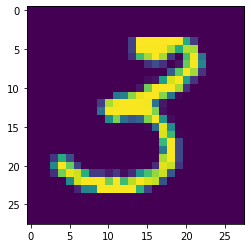

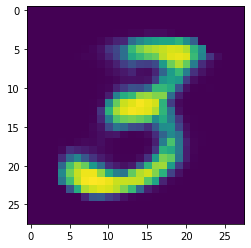

In [13]:
from matplotlib import pyplot as plt
plt.imshow(img_in)
plt.show()
plt.imshow(img_out)
plt.show()

In [14]:
test = model[:2](input)
(test[0]>0).sum()

tensor(193, device='cuda:0')

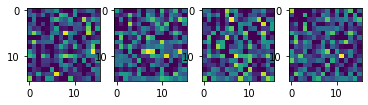

In [15]:
plt.subplot(1,4, 1)
plt.imshow(test[0].detach().cpu().reshape(16,16))
plt.subplot(1,4, 2)
plt.imshow(test[1].detach().cpu().reshape(16,16))
plt.subplot(1,4, 3)
plt.imshow(test[3].detach().cpu().reshape(16,16))
plt.subplot(1,4, 4)
plt.imshow(test[4].detach().cpu().reshape(16,16))
plt.show()

In [16]:
test

tensor([[1.2988, 0.1792, 0.0000,  ..., 1.6887, 0.0000, 1.7168],
        [1.8267, 0.5992, 0.0000,  ..., 1.1410, 1.7359, 1.3392],
        [3.0103, 0.3758, 0.0000,  ..., 1.0756, 2.5721, 2.3930],
        ...,
        [3.1374, 0.0000, 0.0000,  ..., 2.4234, 1.8579, 1.6060],
        [1.7489, 1.0278, 0.0000,  ..., 1.1863, 3.8172, 1.7082],
        [2.9924, 0.0000, 0.0000,  ..., 1.0276, 1.9983, 0.5949]],
       device='cuda:0', grad_fn=<sparse_reluBackward>)

In [17]:
16*16

256